<a href="https://colab.research.google.com/github/JoeCWC/UT_spotify_tracks_recommandation_system/blob/main/autoencoding%2Bkmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 基於 Autoencoder Embedding、Kmeans Cluster 與 Cosine Similarity 的音樂推薦系統。

1. 以歌曲名稱（與可選的 artist）定位目標歌曲
2. 使用 Autoencoder embedding 計算 cosine similarity
3. 優先從同一個 cluster 中挑選最相似的歌曲
4. 若同 cluster 不足，啟動跨 cluster fallback：
   - 每個 cluster 最多取 max_per_cluster 首
   - 依相似度排序後補滿推薦數量
5. 最終輸出統一格式：track_name, artists, cluster, distance

### 參數：
- cluster_col (str): 使用的 cluster 欄位名稱（例如 'cluster_ae_kmeans'）
- embedding_cols (list): Autoencoder embedding 欄位名稱列表
- song_name (str): 目標歌曲名稱
- artist (str, optional): 目標歌曲的藝術家名稱（可選）
- n_recommendations (int): 總共需要的推薦數量
- max_per_cluster (int): 跨 cluster fallback 時，每個 cluster 最多取幾首

### 回傳：
- recommendations (DataFrame): 排序後的推薦歌曲列表


## 實驗方法與步驟

### 1. 資料載入與預處理
*   載入 Spotify 音樂數據集。
*   定義音訊特徵 (audio_features) 和元數據特徵 (meta_features)。
*   移除重複歌曲以避免模型偏差。
*   使用 LabelEncoder 將分類特徵 (如 `artists` 和 `track_genre`) 轉換為數值型，以便模型處理。
*   建立包含所有特徵的集合 `all_features`。

### 2. 特徵縮放與主成分分析 (PCA)
*   對所有特徵進行 `StandardScaler` 縮放處理，使數據標準化。
*   使用 PCA 進行數據探索和視覺化，將數據壓縮到可解釋 95% 變異數的維度，並進一步壓縮到 2D 以進行散佈圖視覺化。

### 3. Autoencoder 模型建立與訓練
*   建立一個包含 Encoder 和 Decoder 的 Autoencoder 神經網路模型。
*   Encoder 將高維輸入壓縮成低維的隱藏表示 (embedding)。
*   Decoder 嘗試從隱藏表示重建原始輸入。
*   模型使用 Adam 優化器和 MSE 損失函數進行編譯。
*   使用 `EarlyStopping` 和 `ReduceLROnPlateau` 回調函數來優化訓練過程，防止過擬合並動態調整學習率。

### 4. KMeans 聚類分析
*   利用訓練好的 Encoder 獲取每首歌曲的低維 embedding。
*   在這些 embedding 上應用 KMeans 演算法進行聚類，將歌曲分成若干個群組 (k=8)。
*   將聚類結果 (`cluster_ae_kmeans`) 添加回 DataFrame。

### 5. 聚類結果視覺化與驗證
*   對 Autoencoder embedding 進行 PCA 降維至 2D，並將聚類結果疊加到散佈圖上，視覺化群組分佈。
*   在原始特徵的 PCA 2D 空間中，再次視覺化聚類結果，以評估群組在原始數據空間中的合理性。

### 6. 自動生成聚類名稱
*   基於每個群組在特定語義特徵 (如 energy, danceability) 上的中心點，自動生成可讀且唯一的聚類名稱。
*   將命名後的群組 (`cluster_name`) 應用於 DataFrame，並更新視覺化圖例。

### 7. 音樂推薦系統建立
*   開發一個基於 Autoencoder embedding、KMeans 聚類和 Cosine Similarity 的音樂推薦系統。
*   該系統能夠根據用戶提供的歌曲名稱和藝術家，推薦相似的歌曲。
*   推薦機制優先從同一群組中選擇最相似的歌曲，並在必要時啟動跨群組的備選機制，確保推薦數量。

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # 掛載 Google Drive；force_remount 確保重新連線（避免路徑殘留）

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

# 建議啟用GPU
* 如果輸出:Num GPUs Available: 1
代表 GPU 已啟用。

* 如果輸出:Num GPUs Available: 0
代表 GPU 沒啟用。

In [ ]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [ ]:
# 讀取 CSV 文件，將數據加載到 DataFrame 中
df = pd.read_csv("/content/drive/MyDrive/HW_Spotify_Tracks/datasets/dataset.csv")
df.info() # 顯示 DataFrame 的簡要資訊，包括每列的數據類型、非空值數量和記憶體使用情況

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [ ]:
# -----------------------------
# 檢查缺失值
# -----------------------------
missing_cols = df.isna().sum()
missing_cols = missing_cols[missing_cols > 0]

for col, missing in missing_cols.items():
    print(f"{col}: {missing} missing")

artists: 1 missing
album_name: 1 missing
track_name: 1 missing


###定義音訊特徵與 metadata 特徵
- audio_features：Spotify 的 9 個連續型音訊特徵
- meta_features：歌曲的歌手、流派、熱門度
### 移除重複歌曲
- 避免同名歌曲造成模型偏差。
### 將類別特徵轉換為數值（Label Encoding）
Autoencoder 與 KMeans 無法處理字串，因此：
- artists → artists_le
- track_genre → genre_le
### 建立最終特徵集合 all_features
包含：
- 9 個 audio features
- popularity（數值）
- artists_le（編碼後的歌手）
- genre_le（編碼後的曲風）


In [ ]:
audio_features = [
    'danceability', 'energy', 'valence', 'liveness', 'acousticness',
    'instrumentalness', 'speechiness', 'tempo', 'loudness'
    ]
meta_features = ['artists','popularity','track_genre']

# 建立副本，避免修改原始 df
df = df.copy()

# 補缺失值（避免 NaN 造成 drop_duplicates 行為不一致）
df['track_name'] = df['track_name'].fillna("Unknown Track")
df['artists'] = df['artists'].fillna("Unknown Artist")

# 依 track_name & artists 刪除重複歌曲，保留第一次出現的記錄，避免推薦系統推薦重複歌曲
df = df.drop_duplicates(subset=['track_name','artists'], keep='first').reset_index(drop=True)

# Label encode artists
le_artist = LabelEncoder()
df['artists_le'] = le_artist.fit_transform(df['artists'])

# Label encode track_genre
le_genre = LabelEncoder()
df['genre_le'] = le_genre.fit_transform(df['track_genre'])

all_features = audio_features + ['popularity', 'artists_le', 'genre_le']

## Scaling + PCA（先看資料結構）
* 這裡的 PCA 先當作「資料探索用」，用來確認音樂特徵是否有可分群的結構

(1) 資料是否呈現出自然的群集？
例如：
- 有明顯的 blob 形狀大致圓或橢圓的資料點群 → KMeans 可能很好用
- 呈現長條狀 / 月牙形 → KMeans 不適合，HDBSCAN / UMAP 會更好
- 完全一團 → 可能需要非線性 embedding（Autoencoder / UMAP）

(2) 是否有離群點？
- 若有明顯孤立點 → clustering 會受影響
- 可能需要先做 outlier removal

(3) 是否有線性可分性？
- 若資料呈現線性方向 → PCA / KMeans 會表現不錯
- 若資料呈現彎曲、非線性 → Autoencoder embedding 會更適合

(4) 是否有「維度塌縮」問題？
如果 2D PCA 看起來像一條線：
- 代表資料高度相關
- clustering 可能會不穩定
- Autoencoder 可能需要更小的 bottleneck


PCA shape: (81344, 10)


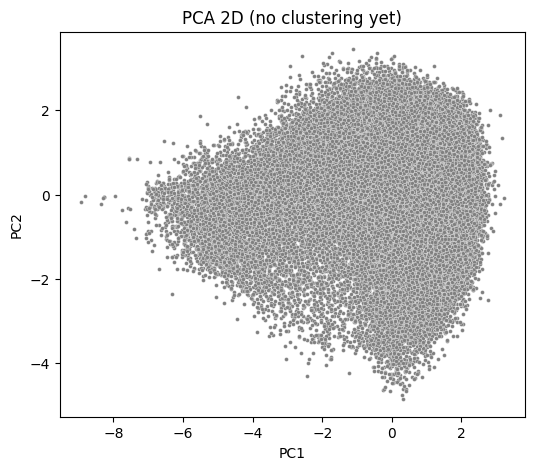

In [ ]:
# Scaling
X = df[all_features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 用於檢查/可視化（先壓到能解釋 95% variance）
pca_full = PCA(n_components=0.95, random_state=42)
Xp = pca_full.fit_transform(X_scaled)
print("PCA shape:", Xp.shape)

# 再壓到 2 維做視覺化用
pca_2d = PCA(n_components=2, random_state=42)
Xp_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.title("PCA 2D (no clustering yet)")
sns.scatterplot(
    x=Xp_2d[:, 0], y=Xp_2d[:, 1], s=8, color='gray'
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## Autoencoder 結構與可調參數說明

此段程式碼建立一個對稱式 Autoencoder，用於將高維特徵壓縮成低維 embedding，
再重建回原始空間。可調整的參數會影響模型容量、壓縮程度與重建品質。

可調參數：
- input_dim (int):
    輸入特徵維度，通常為 X_scaled.shape[1]。
    常見範圍：20–500（依資料集特徵數量而定）

- encoding_dim (int):
    Bottleneck（embedding）維度，決定壓縮程度。
    越小 → 壓縮強、資訊密度高，但可能損失細節
    越大 → 保留更多資訊，但 embedding 不夠精煉
    常見範圍：8、16、32、64

- Dense layer units (64 → 32 → encoding_dim → 32 → 64):
    每層神經元數量決定模型容量。
    Encoder 通常逐層縮小，Decoder 逐層放大。
    常見範圍：
        - 大型模型：128 → 64 → 32 → 64 → 128
        - 中型模型（本例）：64 → 32 → 16 → 32 → 64
        - 小型模型：32 → 16 → 8 → 16 → 32

- activation:
    Encoder/Decoder 隱藏層：relu（最常用）
    Bottleneck：linear（避免壓縮空間被非線性扭曲）
    Output layer：linear（重建連續值）

- optimizer:
    Adam（最常用）
    可調 learning_rate：
        常見範圍：1e-4 ～ 1e-3
        本例：0.0005（中等偏小，較穩定）

- loss:
    mse（適用於連續特徵重建）
    若資料經標準化，mse 是最常見選擇。

此 Autoencoder 結構適合用於：
- 建立低維 embedding（用於 KMeans、相似度搜尋）
- 音樂特徵壓縮
- 後續推薦系統的語意向量表示


In [ ]:
input_dim = X_scaled.shape[1]
encoding_dim = 16

# Autoencoder 結構
input_layer = layers.Input(shape=(input_dim,))

# Encoder
x = layers.Dense(64, activation='relu')(input_layer)
x = layers.Dense(32, activation='relu')(x)
bottleneck = layers.Dense(encoding_dim, activation='linear', name='bottleneck')(x)

# Decoder
x = layers.Dense(32, activation='relu')(bottleneck)
x = layers.Dense(64, activation='relu')(x)
output_layer = layers.Dense(input_dim, activation='linear')(x)

autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
encoder = models.Model(inputs=input_layer, outputs=bottleneck)

# autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

autoencoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,876 (26.86 KB)

 Trainable params: 6,876 (26.86 KB)

 Non-trainable params: 0 (0.00 B)

## Autoencoder 訓練設定說明

本段程式碼負責訓練 Autoencoder，使用 X_scaled 作為輸入與輸出，並透過
EarlyStopping 與 ReduceLROnPlateau 提升收斂穩定度。

參數說明：
- X_scaled: 經標準化後的輸入資料（通常 shape = [n_samples, n_features]）

- epochs (int):
    訓練的最大迭代次數。
    常見範圍：50–500（視模型複雜度與 EarlyStopping 而定）
    若使用 EarlyStopping，通常設較大（如 200–1000）讓模型自行決定停止點。

- batch_size (int):
    每次梯度更新所使用的樣本數。
    常見範圍：32、64、128、256
    越大 → 訓練較穩定但需要更多記憶體；越小 → 噪音較大但可能更快收斂。

- shuffle (bool):
    每個 epoch 是否打亂資料。
    建議：True（避免模型記住資料順序）

- validation_split (float):
    用於驗證的資料比例。
    常見範圍：0.05–0.2
    典型值：0.1（10%）

- callbacks:
    訓練監控工具，用於避免過度訓練與提升收斂品質。

    * EarlyStopping:
        - monitor='val_loss': 監控驗證損失
        - patience=10: 若 10 個 epoch 無改善則停止
        - restore_best_weights=True: 回到最佳模型狀態
        常見 patience：5–20

    * ReduceLROnPlateau:
        - factor=0.5: 學習率降低為原本的一半
        - patience=5: 若 5 個 epoch 無改善則降低學習率
        常見 factor：0.1–0.5
        常見 patience：3–10

- verbose (int):
    訓練過程輸出模式。
    0 = 靜默，1 = 每 epoch 顯示，2 = 每 batch 顯示（較少用）
    常見：1

此設定能確保 Autoencoder 在穩定、可控的情況下收斂，並自動避免過度訓練。


In [ ]:
# 訓練 Autoencoder
history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=200,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    ],
    verbose=1
)

Epoch 1/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.6302 - val_loss: 0.1007 - learning_rate: 5.0000e-04
Epoch 2/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0530 - val_loss: 0.0266 - learning_rate: 5.0000e-04
Epoch 3/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0133 - val_loss: 0.0148 - learning_rate: 5.0000e-04
Epoch 4/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0079 - val_loss: 0.0100 - learning_rate: 5.0000e-04
Epoch 5/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0057 - val_loss: 0.0081 - learning_rate: 5.0000e-04
Epoch 6/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0043 - val_loss: 0.0059 - learning_rate: 5.0000e-04
Epoch 7/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - val_loss: 0.0047 - learning_rate: 5.0000e-04
Epoch 8/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0025 - val_loss: 0.0034 - learning_rate: 5.0000e-04
Epoch 9/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0019 - val_loss:

## 取出 embedding，做 KMeans 分群

In [ ]:
# 取出 embedding（這就是你真正要用的特徵）
X_emb = encoder.predict(X_scaled)
print("Embedding shape:", X_emb.shape)  # (n_samples, encoding_dim)

# 在 embedding 空間做 KMeans
k = 8   # 你可以調整，之後用 PCA 看是否合理
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(X_emb)

df['cluster_ae_kmeans'] = cluster_labels

2542/2542 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Embedding shape: (81344, 16)


## Clustering 評估指標說明（Silhouette / Calinski–Harabasz / Davies–Bouldin）

三者從不同角度衡量群集的緊密度與分離度。

指標與好壞區間：

1. Silhouette Score（輪廓係數）
   - 範圍：-1 ~ 1，越高越好
   - ＞ 0.50：分群效果很好（群之間分離清楚）
   - 0.25–0.50：中等，可接受
   - 0–0.25：弱，群界線模糊
   - ＜ 0：分群錯誤（樣本被分到錯誤群）

2. Calinski–Harabasz Score（CH 指標）
   - 無固定上限，越高越好
   - 衡量群間距離 / 群內緊密度
   - 必須「相對比較不同 k 值」才有意義
   - 越高代表分群越清晰、群內越緊密

3. Davies–Bouldin Index（DBI）
   - 範圍：0 ~ ∞，越低越好
   - ＜ 0.5：非常好
   - 0.5–1.0：良好
   - 1.0–2.0：普通
   - ＞ 2.0：差（群之間重疊嚴重）

此三指標可搭配使用，用於判斷分群品質、選擇最佳 k 值，或比較不同 embedding 方法的效果。


In [ ]:
sil = silhouette_score(X_emb, cluster_labels)
ch = calinski_harabasz_score(X_emb, cluster_labels)
dbi = davies_bouldin_score(X_emb, cluster_labels)
print("\n===== 分群品質指標 =====")
print("Silhouette Score:", sil)
print("Calinski-Harabasz Score:", ch)
print("Davies-Bouldin Index:", dbi)


===== 分群品質指標 =====
Silhouette Score: 0.1551171
Calinski-Harabasz Score: 15618.1
Davies-Bouldin Index: 1.5497154488403444


##用 PCA 檢查 KMeans 是否合理
* 在 AE embedding 上先做 PCA 壓成 2 維，再畫出來看群集是否分得有結構
##在這張圖上可以檢查：
* 各 cluster 是否有明顯區域感（有邊界、不是完全重疊）
* 是否有某些 cluster 特別零碎或特別小（可能 K 設太大）
* 是否有「一坨大球 + 很多小邊緣」的情況（資料本身結構）


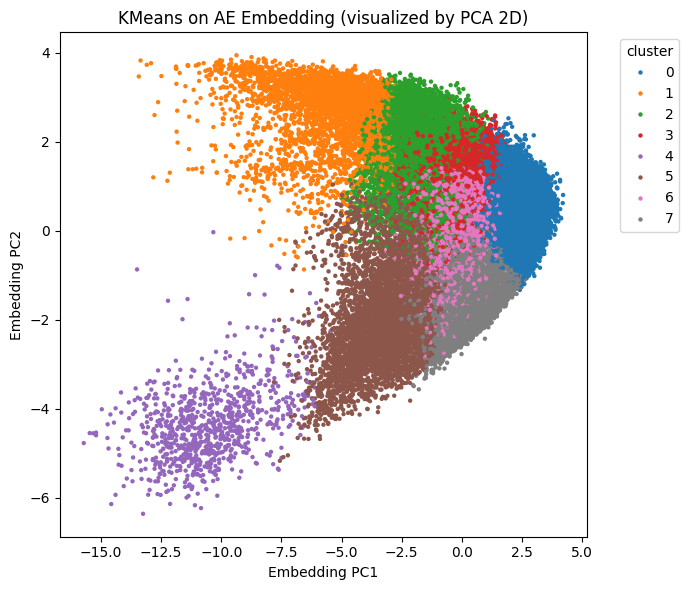

In [ ]:
# 對 embedding 做 PCA (for visualization)
pca_emb_2d = PCA(n_components=2, random_state=42)
X_emb_2d = pca_emb_2d.fit_transform(X_emb)

plt.figure(figsize=(7,6))
plt.title("KMeans on AE Embedding (visualized by PCA 2D)")
sns.scatterplot(
    x=X_emb_2d[:, 0],
    y=X_emb_2d[:, 1],
    hue=df['cluster_ae_kmeans'],
    palette="tab10",
    s=10,
    linewidth=0
)
plt.xlabel("Embedding PC1")
plt.ylabel("Embedding PC2")
plt.legend(title="cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 對原始特徵做 PCA + 上色（看 cluster 映射回原空間）
* 在原始特徵 / 原始 PCA 空間下，AE+KMeans 的 cluster 長什麼樣？是否也合理?
* 是否有某些 cluster 其實在原始空間就已經分得很開
* 是否有 cluster 只是 AE 在 latent space 人工拉開，但原始空間差異不明顯（有時是 good，有時是 overfitting）


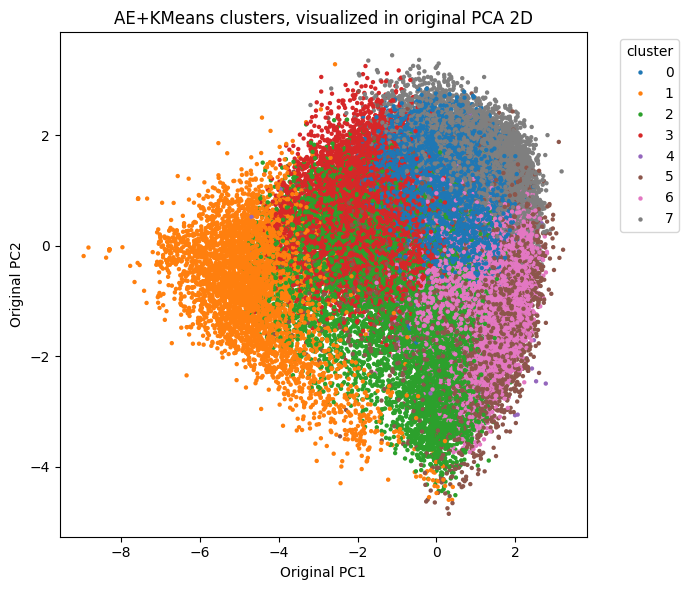

In [ ]:
plt.figure(figsize=(7,6))
plt.title("AE+KMeans clusters, visualized in original PCA 2D")
sns.scatterplot(
    x=Xp_2d[:, 0],
    y=Xp_2d[:, 1],
    hue=df['cluster_ae_kmeans'],
    palette="tab10",
    s=10,
    linewidth=0
)
plt.xlabel("Original PC1")
plt.ylabel("Original PC2")
plt.legend(title="cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 根據每個 cluster 的特徵分佈，自動產生可讀且唯一的叢集名稱。

1. 以指定的 semantic features 計算各 cluster 的中心點（mean vector）
2. 使用 33% 與 66% quantile 將每個特徵分成 Low / Mid / High 三段
3. 為每個 cluster 產生語意化描述（例如：High Energy / Low Acousticness）
4. 若所有特徵皆落在中段，則命名為 "Balanced"
5. 自動避免名稱重複，必要時附加 cluster 編號以確保唯一性

回傳：
- df：新增欄位 `cluster_name` 的 DataFrame
- cluster_names：cluster_id → cluster_name 的字典


In [ ]:
"""
自動命名每個 cluster，保證名稱唯一且可讀
"""
def auto_name_clusters_by_k(df, cluster_col='cluster_ae_kmeans', semantic_features=None):
    if semantic_features is None:
        semantic_features = [
            'energy', 'danceability', 'valence', 'acousticness',
            'instrumentalness', 'tempo', 'loudness',
            'speechiness', 'liveness'
        ]

    # 計算每個 cluster 的中心點
    centroids = df.groupby(cluster_col)[semantic_features].mean()

    # 建立 quantile 區間（每個 feature 會有低、中、高三段）
    quantiles = df[semantic_features].quantile([0.33, 0.66])
    q33 = quantiles.loc[0.33]
    q66 = quantiles.loc[0.66]

    cluster_names = {}
    used_names = set()

    for cluster_id, row in centroids.iterrows():
        descriptors = []

        for feature in semantic_features:
            # 大寫開頭特徵名稱（energy → Energy）
            feat_name = feature.capitalize()

            # 取該特徵的 quantile 切點
            f33 = q33[feature]
            f66 = q66[feature]

            # 低
            if row[feature] < f33:
                descriptors.append(f"Low {feat_name}")
            # 高
            elif row[feature] > f66:
                descriptors.append(f"High {feat_name}")
            # 中間則不命名（避免太冗長）
            else:
                continue

        # 若全部都是中間數值 → 給預設描述
        if not descriptors:
            descriptors.append("Balanced")

        # 合併名稱
        name = " / ".join(descriptors)

        # 避免名稱重複
        if name in used_names:
            name = f"{name} (Cluster {cluster_id})"
        used_names.add(name)

        cluster_names[cluster_id] = name

    df['cluster_name'] = df[cluster_col].map(cluster_names)
    return df, cluster_names



/tmp/ipython-input-765285838.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


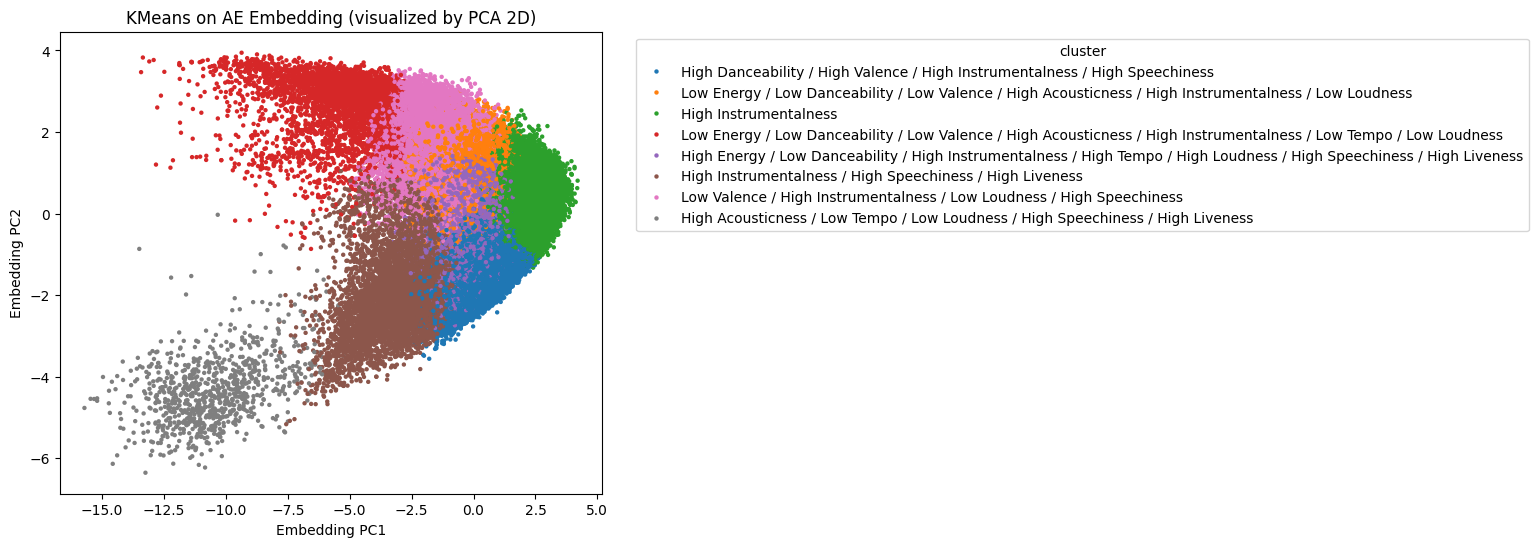

In [ ]:
semantic_features = [
            'energy', 'danceability', 'valence', 'acousticness',
            'instrumentalness', 'tempo', 'loudness',
            'speechiness', 'liveness'
        ]
df, cluster_names = auto_name_clusters_by_k(df, cluster_col='cluster_ae_kmeans', semantic_features=semantic_features)

# Merged cluster 2D visualization
plt.figure(figsize=(7,6))
plt.title("KMeans on AE Embedding (visualized by PCA 2D)")
sns.scatterplot(
    x=X_emb_2d[:, 0],
    y=X_emb_2d[:, 1],
    hue=df['cluster_name'],
    palette="tab10",
    s=10,
    linewidth=0
)
plt.xlabel("Embedding PC1")
plt.ylabel("Embedding PC2")
plt.legend(title="cluster", bbox_to_anchor=(1.05, 1), loc='best')
plt.tight_layout()
plt.show()

## 基於 Autoencoder Embedding、Cluster 與 Cosine Similarity 的混合式音樂推薦系統。

目的：
此函式利用 Autoencoder 壓縮後的 embedding（捕捉歌曲的深層語意特徵），
搭配分群結果（cluster_col）與 cosine similarity，提供更精準且多樣化的歌曲推薦。
推薦邏輯採「同群優先、跨群補足」策略，兼顧相似度與風格多樣性。

優點：
1. **語意更準確的相似度**  
   使用 Autoencoder embedding，而非原始特徵，使相似度更能反映歌曲的整體風格。

2. **同 cluster 優先，提升風格一致性**  
   先從與目標歌曲同群的歌曲中挑選，確保推薦結果風格接近。

3. **跨 cluster fallback，避免推薦不足**  
   若同群歌曲不足，會跨群補足，並限制每個 cluster 的最大推薦數量（max_per_cluster），
   讓推薦結果兼具多樣性與控制性。

4. **避免單一 cluster 過度主導**  
   max_per_cluster 防止某些大群壟斷推薦結果，使推薦更平衡。

5. **可解釋性高**  
   最終輸出包含 track_name、artists、cluster、distance，方便分析推薦來源與相似度。

參數：
- cluster_col (str): 使用的 cluster 欄位名稱（如 'cluster_ae_kmeans'）
- embedding_cols (list): Autoencoder embedding 欄位名稱列表
- song_name (str): 目標歌曲名稱
- artist (str, optional): 目標歌曲的藝術家（可選）
- n_recommendations (int): 需要的推薦數量（預設 5）
- max_per_cluster (int): fallback 時每個 cluster 最多取幾首（預設 2）

回傳：
- recommendations (DataFrame): 最終推薦歌曲列表（含相似度與 cluster）

In [ ]:
def recommend_song_ae_cluster(cluster_col,embedding_cols,song_name,artist=None,n_recommendations=5,max_per_cluster=2):
    """
    Autoencoder + Cluster + Cosine Similarity 推薦系統
    - cluster_col: 使用哪個 cluster 欄位（例如 'cluster_ae_kmeans'）
    - embedding_cols: Autoencoder embedding 欄位（list）
    - max_per_cluster: 跨 cluster 時，每個 cluster 最多取幾首
    """

    # 找目標歌曲
    if artist:
        song = df[(df['track_name'].str.lower() == song_name.lower()) &
                  (df['artists'].str.lower() == artist.lower())]
    else:
        song = df[df['track_name'].str.lower() == song_name.lower()]

    if song.empty:
        print(f"❌ Song '{song_name}' not found in dataset.")
        return None

    song_index = song.index[0]
    song_emb = df.loc[song_index, embedding_cols].values.reshape(1, -1)
    song_cluster = df.loc[song_index, cluster_col]

    # 同 cluster 篩選
    same_cluster = df[(df[cluster_col] == song_cluster) & (df.index != song_index)].copy()

    # 計算 cosine similarity
    same_cluster['distance'] = cosine_similarity(
        same_cluster[embedding_cols].values, song_emb
    ).reshape(-1)

    # 先取同 cluster 的推薦
    recommendations = same_cluster.sort_values('distance', ascending=False).head(n_recommendations)

    # fallback：跨 cluster，但限制每個 cluster 最多 max_per_cluster 首
    if len(recommendations) < n_recommendations:

        remaining_n = n_recommendations - len(recommendations)

        other = df[df.index != song_index].copy()
        other = other[~other.index.isin(recommendations.index)]

        # 計算 cosine similarity
        other['distance'] = cosine_similarity(
            other[embedding_cols].values, song_emb
        ).reshape(-1)

        # 按 cluster 分組，每個 cluster 取 max_per_cluster 首
        fallback_list = []
        for c, group in other.groupby(cluster_col):
            top_c = group.sort_values('distance', ascending=False).head(max_per_cluster)
            fallback_list.append(top_c)

        fallback_df = pd.concat(fallback_list).sort_values('distance', ascending=False)

        # 取剩下需要的數量
        fallback_final = fallback_df.head(remaining_n)

        # 合併
        recommendations = pd.concat([recommendations, fallback_final])

    # 輸出格式統一
    recommendations = recommendations.copy()
    recommendations['cluster'] = recommendations[cluster_col]
    recommendations = recommendations[['track_name', 'artists', 'cluster', 'distance']]

    print(f"\n🎵 Recommendations for '{song_name}' (Artist: {artist if artist else 'Any'}):")
    # print(recommendations)

    return recommendations

In [ ]:
# 自動建立 embedding 欄位名稱
embedding_cols = [f"emb_{i}" for i in range(X_emb.shape[1])]
# 寫入 df
df[embedding_cols] = X_emb

recommend_song_ae_cluster(cluster_col="cluster_ae_kmeans",embedding_cols=embedding_cols,song_name="Comedy",artist="Gen Hoshino")


🎵 Recommendations for 'Comedy' (Artist: Gen Hoshino):


,track_name,artists,cluster,distance
13373,Butterflies,Fiji Blue,7,0.994472
13798,COLORWAY,DESTIN CONRAD,7,0.994398
4515,馬と鹿,Kenshi Yonezu,7,0.993604
13773,Used to Me,Luke Chiang,7,0.993323
13015,Strawberry Skies,Kid Travis,7,0.992104
